In [19]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

In [20]:

env = gym.make('CartPole-v1')
env.reset(seed=0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n



state,_ = env.reset()




### Q-Network:
The neural network used as a function approximator is defined below

In [21]:


import torch
import torch.nn as nn
import torch.nn.functional as F




class QNetwork1(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork1, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        # Advantage stream
        self.fc_advantage = nn.Linear(fc2_units, action_size)

        # Value stream
        self.fc_value = nn.Linear(fc2_units, 1)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        advantage = self.fc_advantage(x)

        # Value stream
        value = self.fc_value(x)

        # Combine value and advantage to get Q-values
        Q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))

        return Q_values



class QNetwork2(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork2, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        # Advantage stream
        self.fc_advantage = nn.Linear(fc2_units, action_size)

        # Value stream
        self.fc_value = nn.Linear(fc2_units, 1)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        advantage = self.fc_advantage(x)

        # Value stream
        value = self.fc_value(x)

        # Combine value and advantage to get Q-values
        Q_values = value + (advantage - advantage.max(dim=1, keepdim=True)[0])

        return Q_values

### Replay Buffer:

Recall why we use such a technique.

In [22]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Tutorial Agent Code:


In [23]:
class TutorialAgent1():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        Q_targets_next = self.qnetwork_target(next_states)

        # Compute value and advantage streams
        next_state_values = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * next_state_values * (1 - dones))

        # Compute Q-values for current states using local network
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [24]:
class TutorialAgent2():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork2(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork2(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):
        state=np.array(state)
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        Q_targets_next = self.qnetwork_target(next_states)

        # Compute value and advantage streams
        next_state_values = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * next_state_values * (1 - dones))

        # Compute Q-values for current states using local network
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

### Here, we present the DQN algorithm code.

In [27]:
''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n


def dqn(agent,n_episodes=10000, max_t=500, eps_start=0.4, eps_end=0.01, eps_decay=0.995):

    scores_window = deque(maxlen=100)
    all_scores=np.array([])
    moving_avg_scores=np.array([])
    done,truncated=False,False
    eps = eps_start
    ''' initialize epsilon '''

    for i_episode in range(1, n_episodes+1):
        state,_ = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state,reward, done, truncated,_ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done :
                break
        scores_window.append(score)
        all_scores=np.append(all_scores,score)

        eps = max(eps_end, eps_decay*eps)
        ''' decrease epsilon '''

        moving_avg_scores=np.append(moving_avg_scores,np.mean(scores_window))

  
        if i_episode==1000:
           break
    return moving_avg_scores,True



In [32]:
env = gym.make('CartPole-v1')
env.reset(seed=0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n
state = env.reset()

In [54]:
BUFFER_SIZE = 100000  # replay buffer size
BATCH_SIZE = 64      # minibatch size
GAMMA = 0.99            # discount factor
LR = 0.0001736            # learning rate
UPDATE_EVERY = 20
# cartpole mean
agent = TutorialAgent1(state_size=state_shape,action_size = action_shape,seed = 0)
all1=[]
for i in range(5):
  print(i)
  env.reset(seed=np.random.randint(1,100))
  all_scores_1=dqn(agent)
  all1.append(all_scores_1[0])

average_return_1 = np.mean(all1, axis=0)

0
1
2
3
4


In [55]:
BUFFER_SIZE = 1000  # replay buffer size
BATCH_SIZE = 32        # minibatch size
GAMMA = 0.99            # discount factor
LR = 0.0002026           # learning rate
UPDATE_EVERY = 50
# cartpole max
agent2=TutorialAgent2(state_size=state_shape,action_size = action_shape,seed = 0)
all2=[]
for i in range(5):
  print(i)
  env.reset(seed=np.random.randint(1,100))
  all_scores_2=dqn(agent2)
  all2.append(all_scores_2[0])
average_return_2 = np.mean(all2, axis=0)

0
1
2
3
4


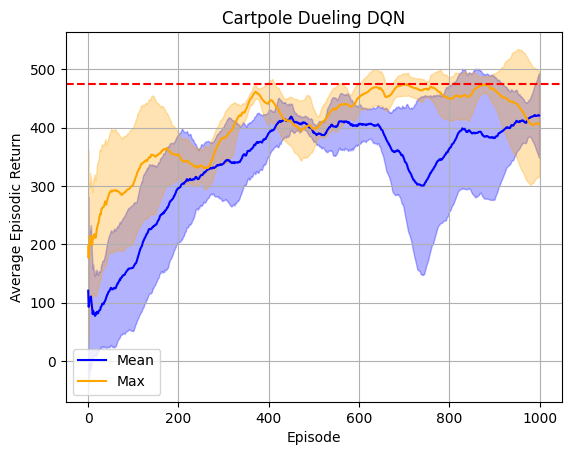

In [48]:
import matplotlib.pyplot as plt
import numpy as np

std_return_1 = np.std(all1, axis=0)
std_return_2 = np.std(all2, axis=0)

# Plot both average episodic returns with variance shaded
plt.plot(average_return_1, label='Mean', color='blue')
plt.fill_between(range(len(average_return_1)), average_return_1 - std_return_1, average_return_1 + std_return_1, color='blue', alpha=0.3)

plt.plot(average_return_2, label='Max', color='orange')
plt.fill_between(range(len(average_return_2)), average_return_2 - std_return_2, average_return_2 + std_return_2, color='orange', alpha=0.3)
plt.axhline(y=475, color='red', linestyle='--')
plt.xlabel('Episode')
plt.ylabel('Average Episodic Return')
plt.title('Cartpole Dueling DQN')
plt.legend()  # Show legend to distinguish between the two lines
plt.grid(True)
plt.show()


In [8]:
env = gym.make('Acrobot-v1')
env.reset(seed=0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n
state = env.reset()


In [11]:
BUFFER_SIZE = 100000 # replay buffer size
BATCH_SIZE = 32       # minibatch size
GAMMA = 0.99            # discount factor
LR = 0.0005974          # learning rate
UPDATE_EVERY = 75
# Acrobot mean
agent3 = TutorialAgent1(state_size=state_shape,action_size = action_shape,seed = 0)
all3=[]
for i in range(5):
  env.reset(seed=np.random.randint(1,100))
  all_scores_3=dqn(agent3)
  all3.append(all_scores_3[0])

average_return_3 = np.mean(all3, axis=0)



In [12]:
BUFFER_SIZE = 100000  # replay buffer size
BATCH_SIZE = 128      # minibatch size
GAMMA = 0.99            # discount factor
LR = 0.00304          # learning rate
UPDATE_EVERY = 20
# acrobot max
agent4=TutorialAgent2(state_size=state_shape,action_size = action_shape,seed = 0)
all4=[]
for i in range(5):
  env.reset(seed=np.random.randint(1,100))
  all_scores_4=dqn(agent4)
  all4.append(all_scores_4[0])
average_return_4 = np.mean(all4, axis=0)

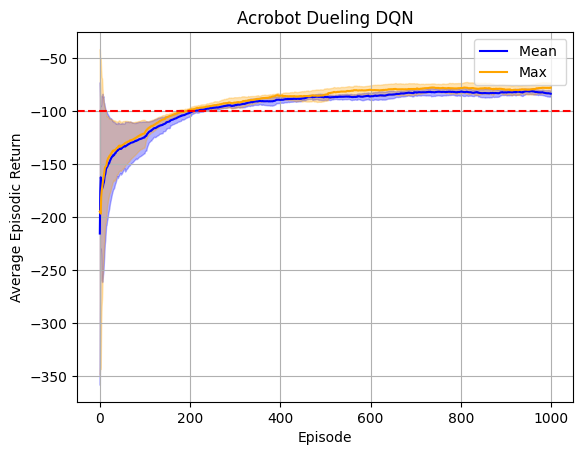

In [36]:
std_return_3 = np.std(all3, axis=0)
std_return_4 = np.std(all4, axis=0)

# Plot both average episodic returns with variance shaded
plt.plot(average_return_3, label='Mean ', color='blue')
plt.fill_between(range(len(average_return_3)), average_return_3 - std_return_3, average_return_3 + std_return_3, color='blue', alpha=0.3)

plt.plot(average_return_4, label='Max', color='orange')
plt.fill_between(range(len(average_return_4)), average_return_4 - std_return_4, average_return_4 + std_return_4, color='orange', alpha=0.3)
plt.axhline(y=-100, color='red', linestyle='--')
plt.xlabel('Episode')
plt.ylabel('Average Episodic Return')
plt.title('Acrobot Dueling DQN')
plt.legend()  # Show legend to distinguish between the two lines
plt.grid(True)
plt.show()